## RANDOM FOREST - Baseline with "Balanced" class weight


In [14]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
FEATURES_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/feature_engineering_model/temp.csv"
LABELS_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/data_gpt_labeler/final_data_labeled_1.csv"
TEXT_COL = "text"
TARGET_COL = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]

In [ ]:

# load files
df_feat  = pd.read_csv(FEATURES_CSV)
df_label = pd.read_csv(LABELS_CSV)

In [ ]:
# merge by index order
df = pd.concat(
    [df_feat.reset_index(drop=True), 
     df_label[[TARGET_COL, TEXT_COL]].reset_index(drop=True)], 
    axis=1
)

print("Merged dataset:", df.shape)
df.head()

Merged dataset: (10000, 7)


,A,B,D2,E,G,policy_label,text
0,0.126823,0.581653,0.660104,0.993421,0.999407,1,My husband took me here for my birthday! The ...
1,0.066522,0.565305,0.620909,0.360918,0.997275,1,was a great place. Now closed. Too bad. We'll...
2,0.158263,0.575038,0.551840,0.987322,0.999049,1,"cozy, great food. love how you can sign your b..."
3,0.062633,0.575837,0.630236,0.859828,0.999422,1,"Not your average little Italian joint, don't e..."
4,0.005904,0.572793,0.792418,0.901759,0.999557,1,Service was great and the mozzarella fritta an...


In [6]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance:", dict(zip(*np.unique(y, return_counts=True))))


X shape: (10000, 5)
y shape: (10000,)
Class balance: {np.int64(0): np.int64(1090), np.int64(1): np.int64(8910)}


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if len(np.unique(y)) == 2 else None
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8000, 5) Test size: (2000, 5)


In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=200,           # number of trees
    max_depth=None,             # let it grow fully
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"     # important for imbalance
)

rf_clf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.891

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.1468    0.2270       218
           1     0.9039    0.9820    0.9414      1782

    accuracy                         0.8910      2000
   macro avg     0.7020    0.5644    0.5842      2000
weighted avg     0.8599    0.8910    0.8635      2000


Confusion Matrix:
 [[  32  186]
 [  32 1750]]


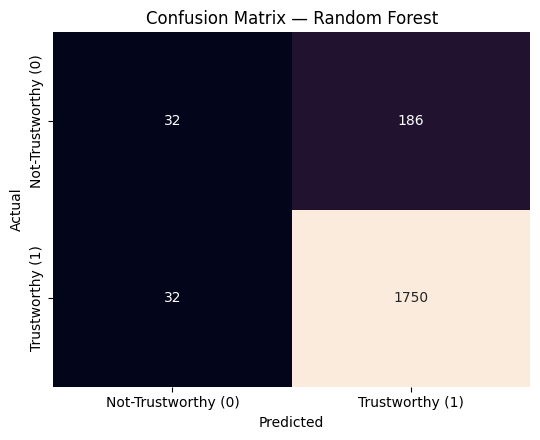

In [10]:
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    cm, annot=True, fmt="d", cbar=False,
    xticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"],
    yticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"]
)
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [13]:
df = pd.read_csv("/Users/evan/Documents/Projects/TikTok-TechJam-2025/data_gpt_labeler/final_data_labeled_3.csv")
length = len(df[df['policy_label'].isna()])
print(f"Number of NaN values: {length}")


Number of NaN values: 4771


## Random Forest with (class_weight="balanced" + CV threshold tuning)

In [ ]:
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix ,precision_recall_curve, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FINAL_CSV   = "../final_data_featured_filtered.csv"
TARGET_COL  = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]

In [3]:
df = pd.read_csv(FINAL_CSV)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:20])
missing = [c for c in FEATURE_COLS + [TARGET_COL] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

Loaded shape: (31120, 6)
Columns: ['A', 'B', 'D2', 'E', 'G', 'policy_label']


In [4]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].astype(int).values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (24896, 5)  Test: (6224, 5)


RF Baseline Accuracy: 0.8374035989717223
              precision    recall  f1-score   support

           0     0.3926    0.6156    0.4794       757
           1     0.9422    0.8681    0.9037      5467

    accuracy                         0.8374      6224
   macro avg     0.6674    0.7419    0.6915      6224
weighted avg     0.8754    0.8374    0.8521      6224



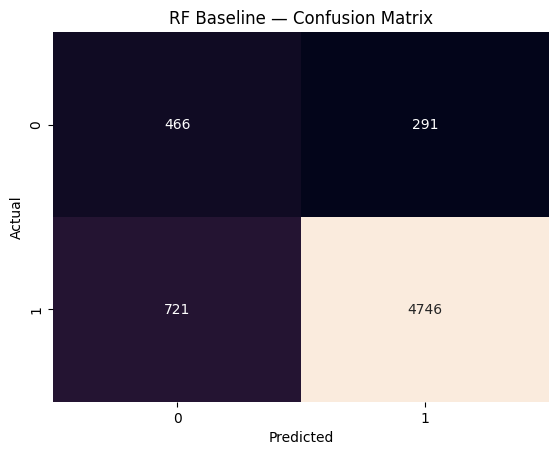

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# baseline fitting
rf_baseline = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

y_pred_rf = rf_baseline.predict(X_test)

print("RF Baseline Accuracy:", accuracy_score(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf, digits=4))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, 
            fmt="d", 
            cbar=False,
            xticklabels=["0","1"], 
            yticklabels=["0","1"])
plt.title("RF Baseline — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()


In [ ]:
# fitting with CV and threshold tuning

rf_cv_metrics = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X[tr], X[va]
    y_tr, y_va = y[tr], y[va]

    clf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)

    p = clf.predict_proba(X_va)[:, 1]
    prec, rec, thr = precision_recall_curve(y_va, p)

    beta = 2
    best = None
    for t in thr:
        y_hat = (p >= t).astype(int)
        tp0 = np.sum((y_hat == 0) & (y_va == 0))
        fp0 = np.sum((y_hat == 0) & (y_va == 1))
        fn0 = np.sum((y_hat == 1) & (y_va == 0))
        prec0 = tp0 / (tp0 + fp0 + 1e-12)
        rec0  = tp0 / (tp0 + fn0 + 1e-12)
        f2_0  = (1 + beta**2) * (prec0 * rec0) / (beta**2 * prec0 + rec0 + 1e-12)
        if (best is None) or (f2_0 > best[0]):
            best = (f2_0, prec0, rec0, t)

    f2_0, prec0, rec0, t_best = best
    y_hat = (p >= t_best).astype(int)
    cm = confusion_matrix(y_va, y_hat)

    rf_cv_metrics.append({
        "fold": fold,
        "threshold": float(t_best),
        "prec0": float(prec0),
        "rec0": float(rec0),
        "f2_0": float(f2_0),
        "f1_macro": float(f1_score(y_va, y_hat, average="macro")),
        "cm": cm
    })

for m in rf_cv_metrics:
    print(f"[RF ] Fold {m['fold']} | Th={m['threshold']:.3f} | Prec0={m['prec0']:.3f} | "
          f"Rec0={m['rec0']:.3f} | F2_0={m['f2_0']:.3f} | F1_macro={m['f1_macro']:.3f}")
    print(m["cm"], "\n")

print("[RF ] Avg Prec0:", np.mean([m["prec0"] for m in rf_cv_metrics]))
print("[RF ] Avg Rec0 :", np.mean([m["rec0"] for m in rf_cv_metrics]))


[RF ] Fold 1 | Th=0.657 | Prec0=0.310 | Rec0=0.787 | F2_0=0.602 | F1_macro=0.646
[[ 595  161]
 [1326 4142]] 

[RF ] Fold 2 | Th=0.708 | Prec0=0.271 | Rec0=0.767 | F2_0=0.561 | F1_macro=0.609
[[ 580  176]
 [1561 3907]] 

[RF ] Fold 3 | Th=0.748 | Prec0=0.263 | Rec0=0.853 | F2_0=0.589 | F1_macro=0.597
[[ 646  111]
 [1812 3655]] 

[RF ] Fold 4 | Th=0.713 | Prec0=0.277 | Rec0=0.828 | F2_0=0.592 | F1_macro=0.614
[[ 627  130]
 [1637 3830]] 

[RF ] Fold 5 | Th=0.724 | Prec0=0.272 | Rec0=0.831 | F2_0=0.589 | F1_macro=0.608
[[ 629  128]
 [1685 3782]] 

[RF ] Avg Prec0: 0.2784436806037716
[RF ] Avg Rec0 : 0.8133564683762822


## Updated RF Pipeline with SMOTE + Tomek

In [8]:
from imblearn.combine import SMOTETomek 

In [9]:
FINAL_CSV   = "../final_data_featured_filtered.csv"
TARGET_COL  = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]

In [10]:
df = pd.read_csv(FINAL_CSV)
print("Loaded shape:", df.shape)

Loaded shape: (31120, 6)


In [11]:

X = df[FEATURE_COLS].values
y = df[TARGET_COL].astype(int).values
print("Class balance:", dict(zip(*np.unique(y, return_counts=True))))

Class balance: {np.int64(0): np.int64(3783), np.int64(1): np.int64(27337)}


In [ ]:
# CV + Threshold Tuning with SMOTE+Tomek

def evaluate_with_smote_tomek(model, X, y, model_name="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    smt = SMOTETomek(random_state=42)   # 👈 combo resampler

    metrics = []

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_va, y_va = X[va], y[va]

        # resample training set only
        X_res, y_res = smt.fit_resample(X_tr, y_tr)

        # rit
        model.fit(X_res, y_res)

        # probs and threshold tuning for class 0
        p = model.predict_proba(X_va)[:, 1]
        prec, rec, thr = precision_recall_curve(y_va, p)

        beta = 2
        best = None
        for t in thr:
            y_hat = (p >= t).astype(int)
            tp0 = np.sum((y_hat == 0) & (y_va == 0))
            fp0 = np.sum((y_hat == 0) & (y_va == 1))
            fn0 = np.sum((y_hat == 1) & (y_va == 0))
            prec0 = tp0 / (tp0 + fp0 + 1e-12)
            rec0  = tp0 / (tp0 + fn0 + 1e-12)
            f2_0  = (1 + beta**2) * (prec0 * rec0) / (beta**2 * prec0 + rec0 + 1e-12)
            if (best is None) or (f2_0 > best[0]):
                best = (f2_0, prec0, rec0, t)

        f2_0, prec0, rec0, t_best = best
        y_hat = (p >= t_best).astype(int)
        cm = confusion_matrix(y_va, y_hat)

        metrics.append({
            "fold": fold,
            "threshold": float(t_best),
            "prec0": float(prec0),
            "rec0": float(rec0),
            "f2_0": float(f2_0),
            "f1_macro": float(f1_score(y_va, y_hat, average="macro")),
            "cm": cm
        })

    print(f"=== {model_name} with SMOTE+Tomek ===")
    for m in metrics:
        print(f"Fold {m['fold']} | Th={m['threshold']:.3f} | "
              f"Prec0={m['prec0']:.3f} | Rec0={m['rec0']:.3f} | "
              f"F2_0={m['f2_0']:.3f} | F1_macro={m['f1_macro']:.3f}")
        print(m["cm"], "\n")

    print(f"[{model_name}] Avg Prec0:", np.mean([m["prec0"] for m in metrics]))
    print(f"[{model_name}] Avg Rec0 :", np.mean([m["rec0"] for m in metrics]))
    return metrics


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=10,
    class_weight=None,   
    random_state=42,
    n_jobs=-1
)

rf_metrics = evaluate_with_smote_tomek(rf_model, X, y, "Random Forest")


=== Random Forest with SMOTE+Tomek ===
Fold 1 | Th=0.540 | Prec0=0.323 | Rec0=0.746 | F2_0=0.591 | F1_macro=0.657
[[ 564  192]
 [1180 4288]] 

Fold 2 | Th=0.659 | Prec0=0.255 | Rec0=0.784 | F2_0=0.554 | F1_macro=0.591
[[ 593  163]
 [1735 3733]] 

Fold 3 | Th=0.663 | Prec0=0.262 | Rec0=0.824 | F2_0=0.576 | F1_macro=0.597
[[ 624  133]
 [1760 3707]] 

Fold 4 | Th=0.563 | Prec0=0.302 | Rec0=0.754 | F2_0=0.580 | F1_macro=0.639
[[ 571  186]
 [1322 4145]] 

Fold 5 | Th=0.567 | Prec0=0.305 | Rec0=0.748 | F2_0=0.580 | F1_macro=0.642
[[ 566  191]
 [1288 4179]] 

[Random Forest] Avg Prec0: 0.2893576056829586
[Random Forest] Avg Rec0 : 0.7713422518574423
